In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/erinfoley/Desktop/nasa2024/data/ccri_tidy_chla_processed_data_V2.csv")
lagosid = pd.read_csv("/Users/erinfoley/Desktop/nasa2024/data/ccri_lakes_withLagosID.csv")

# merge lake data with main dataset
lagosid = lagosid[['MEAN_lat', 'MEAN_long', 'lagoslakei']]
df = pd.concat([lagosid, df], axis=1)

# filter
df = df[df['443'].notna()]

# create chl-a mathematical inputs - FROM MEETING: don't do this
df["NDCI"] = ((df['703'] - df['665']) / (df['703'] + df['665']))
df["NDVI"] = ((df['864'] - df['665']) / (df['864'] + df['665']))
df["3BDA"] = (((df['493'] - df['665']) / (df['493'] + df['665'])) - df['560'])

# create rough volume based on depth & surface area
df["lake_vol"] = (df['SA'] * df['Max.depth'])

# koad LAGOS-NE IWS data, merged with dataframe
iws_lulc = pd.read_csv("/Users/erinfoley/Desktop/nasa2024/data/LAGOSNE_iws_lulc105.csv")

# summarize percent developed land
iws_lulc['iws_nlcd2011_pct_dev'] = iws_lulc['iws_nlcd2011_pct_21'] + iws_lulc['iws_nlcd2011_pct_22'] + iws_lulc['iws_nlcd2011_pct_23'] + iws_lulc['iws_nlcd2011_pct_24']

# summarize percent agricultural land
iws_lulc['iws_nlcd2011_pct_ag'] = iws_lulc['iws_nlcd2011_pct_81'] + iws_lulc['iws_nlcd2011_pct_82']

# create new dataframe with the two variables
iws_human = iws_lulc[['lagoslakeid', 'iws_nlcd2011_pct_dev', 'iws_nlcd2011_pct_ag']]
iws_human = iws_human.rename(columns={'lagoslakeid': 'lagoslakei', 'iws_nlcd2011_pct_dev': 'pct_dev', 'iws_nlcd2011_pct_ag': 'pct_ag'})

# merge df with iws_human
df = df.merge(iws_human, on="lagoslakei")

# prepare features and target variable
features = df[['443', '493', '560', '665', '864', 'NDCI', 'NDVI', '3BDA', 'lake_vol', 'pct_dev', 'pct_ag']].to_numpy()
chla = df["chl_a"].to_numpy()

# natural log transform chl-a - don't fully understand
chla_log = np.log(chla + 0.01)  # Add a small value to avoid log(0)


Model Performance
Mean Absolute Error: 0.483
Root Mean Squared Error: 0.729
R^2 Score: 0.643


/Users/erinfoley/CGSCI-Research-Synonymy/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


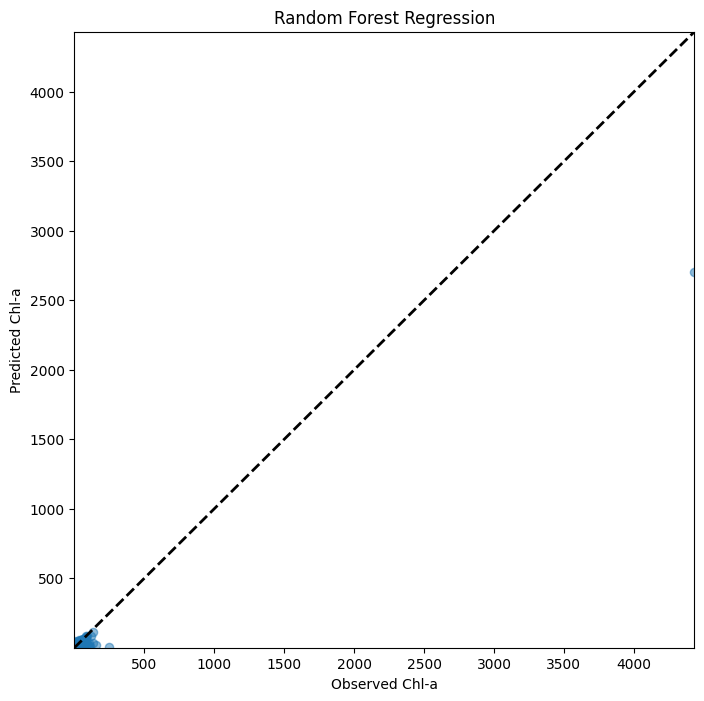

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# split
x_train, x_test, y_train, y_test = train_test_split(features, chla_log, test_size=0.1, random_state=42)

# initialize  RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# train
rf.fit(x_train, y_train)

# predict
y_pred = rf.predict(x_test)

# evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Model Performance")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")


# inverse the log transformation for the actual vs predicted plot
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

min_value = min(y_test_exp.min(), y_pred_exp.min())
max_value = max(y_test_exp.max(), y_test_exp.max())

plt.figure(figsize=(8, 8))
plt.scatter(y_test_exp, y_pred_exp, alpha=0.5, s=35)
plt.plot([min_value, max_value], [min_value, max_value], 'k--', lw=2)
plt.xlabel('Observed Chl-a')
plt.ylabel('Predicted Chl-a')
plt.title('Random Forest Regression')
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)
plt.show()